In [34]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit
from sympy import Matrix
import time
from scipy import sparse

from iminuit import cost, Minuit
# faster than scipy.stats functions
from numba_stats import truncnorm, truncexpon, norm, expon
from scipy.stats import multivariate_normal as mvnorm

ModuleNotFoundError: No module named 'iminuit'

In [84]:
def index_map(x, y, L):
    if x>L or y>L: return None
    return x*L + y

def linear_fit(x, m, b):
    return m*x + b
def power_law(x, a):
    return x**(-a)

def power_law_scale(x, a, scale):
    return scale*x**(-a)

def exponential_dist_norm(x, a):
    return a*np.exp(-a*x)

def exponential_dist(x, A, b):
    return A*np.exp(-b*x)

In [ ]:
def random_nnDist(a,b,custDist,size=None, nControl=10**6):
    #genearte a list of size random samples, obeying the distribution custDist
    #suggests random samples between x0 and x1 and accepts the suggestion with probability custDist(x)
    #custDist noes not need to be normalized. Add this condition to increase performance. 
    #Best performance for max_{x in [x0,x1]} custDist(x) = 1
    samples=[]
    nLoop=0
    
    low = 0
    high = (np.sqrt(a**2 + 2*b) - a)/b
    
    while len(samples)<size and nLoop<nControl:
        x=np.random.uniform(low=low,high=high)
        prop=custDist(x, a, b)
        assert prop>=0 and prop<=1
        if np.random.uniform(low=0,high=1) <=prop:
            samples += [x]
        nLoop+=1
    return samples

def random_nnnDist(w,a,b,custDist,size=None, nControl=10**6):
    samples=[]
    nLoop=0
    
    low = w
    high = (np.sqrt(a**2 + 2*b*(1+a*w+b*w**2/2))-a)/b
    
    while len(samples)<size and nLoop<nControl:
        x=np.random.uniform(low=low,high=high)
        prop=custDist(x, a, b)
        assert prop>=0 and prop<=1
        if np.random.uniform(low=0,high=1) <=prop:
            samples += [x]
        nLoop+=1
    return samples


#call
a=0.1
b=1
def linDist(x, a, b):
    return a + b*x
samples=random_nnDist(a,b,custDist=linDist,size=100000)
#print(samples)

plt.hist(np.array(samples), density=True, bins = 20)

x = np.linspace(0, (np.sqrt(a**2 + 2*b) - a)/b, 1000)

plt.plot(x, np.array(linDist(x, a, b)))

In [86]:
def update_adjacency_J_ij(adj_ind, i, j):
    #Updates adjaceny set of i with that of j
    #Also deletes index from the adjacency list of other indices
    adj_i = adj_ind[i]
    adj_j = adj_ind[j]
    
    adj_i_new = list(set(adj_i+adj_j))
    adj_i_new = list(set(adj_i_new)-set([i, j]))
    adj_ind[i] = adj_i_new
    adj_ind[j] = []
    
    for k in adj_i_new:
        adj_ind[k] = list(set(adj_ind[k]+[i])-set([j]))
        
    return None

def update_adjacency_h(adj_ind, i):
    #Updates adjacency set of every element in adj(i) with adj(i)
    #Also deletes index i from adj(k) for all k in adj(i)
    adj_i = adj_ind[i]
    
    for k in adj_ind[i]:
        adj_ind[k] = list(set(adj_ind[k]+adj_i)-set([i]))
        
    adj_ind[i] = []
    return None
   
#Cluster tracking using a dictionary
#Key is the lattice index, value is the index of the dictionary


def update_cluster(cluster_dict, reverse_dict,site1, site2):
    #Takes in a dictionary containing the site->cluster mapping, cluster->set of sites mapping, and the two sites being decimated
    #Returns updated dictionaries, containing the new cluster data
    clust1 = cluster_dict[site1]   #cluster of site 1
    clust2 = cluster_dict[site2]   #cluster of site 2
    
    #Add spins in clust2 to clust1
    for dec_site in reverse_dict[clust2]:
        cluster_dict[dec_site] = clust1
    
    reverse_dict[clust1] += reverse_dict[clust2]
    reverse_dict[clust2] = None
    
    return cluster_dict, reverse_dict

In [87]:
def triangle_lattice_boundary_dictionary(L, include_nnn=False):
    ind_dict = {}
    adj_ind = {}
    bdry_dict = np.zeros(L*L,dtype=bool)
    
    for x in range(L):
        for y in range(L):
            ind_0 = index_map(x,y,L)
            
            #nn indices
            adjs = [index_map(x,(y-1)%L, L), index_map(x,(y+1)%L, L)]
            
            if include_nnn: adjs += [index_map(x,(y+2)%L, L), index_map(x,(y-2)%L, L)]
            
            if x-1>=0:
                adjs.append(index_map((x-1)%L,y, L))
                adjs.append(index_map((x-1)%L,(y-(-1)**(x%2))%L, L))
                
                if include_nnn: adjs += [index_map((x-1)%L,(y+(-1)**(x%2))%L, L), index_map((x-1)%L,(y-2*(-1)**(x%2))%L, L)]
            if x+1<L:
                adjs.append(index_map((x+1),y, L))
                adjs.append(index_map((x+1),(y-(-1)**(x%2))%L, L))
                
                if include_nnn: adjs += [index_map((x+1)%L,(y+(-1)**(x%2))%L, L), index_map((x+1)%L,(y-2*(-1)**(x%2))%L, L)]
            
            if include_nnn:
                if x-2>=0:
                    adjs += [index_map((x-2)%L,y, L), index_map((x-2)%L,(y+1)%L, L), index_map((x-2)%L,(y-1)%L, L)]
                if x+2<L:
                    adjs += [index_map((x+2)%L,y, L), index_map((x+2)%L,(y+1)%L, L), index_map((x+2)%L,(y-1)%L, L)]
            
            if x==0: bdry_dict[ind_0] = True
            elif x==(L-1): bdry_dict[ind_0] = True      
                
            ind_dict[ind_0] = (x,y)
            adj_ind[ind_0] = list(set(adjs))
    return ind_dict, adj_ind, bdry_dict

In [31]:
class boundary_system:
    
    def __init__(self, size, adj_ind, bdry_dict, J_ij_vals, h_vals):
        
        self.size = size
        self.adj_ind = adj_ind
        self.J_ij_vals = J_ij_vals
        self.h_vals = h_vals
        self.bdry_dict = bdry_dict
        
        self.Gamma_array = []
        self.Omega_0 = max(h_vals.max(), J_ij_vals.max())
        self.Omega = self.Omega_0
        
        self.cluster_tracker = np.ones(size)
        self.cluster_ind = np.arange(size)
        
        self.clust_dict = {i:i for i in range(size)}
        self.reverse_dict = {i:[i] for i in range(size)}  #Cluster index is key and vals is set with lattice indices in cluster 
        
        return None
    
    def decimate(self):
        Omega = max(self.h_vals.max(), self.J_ij_vals.max())
        self.Omega = Omega
        self.Gamma_array.append(np.log(self.Omega_0/Omega))
        if Omega == self.J_ij_vals.max(): self.J_decimation(Omega)
        elif Omega == self.h_vals.max(): self.h_decimation(Omega)
        
        return None
    
    def J_decimation(self, Omega):
        r_ind, c_ind, J_ij = sparse.find(self.J_ij_vals) 
        J_ind = np.where(J_ij == Omega)[0][0]
        i, j = r_ind[J_ind], c_ind[J_ind]

        self.h_vals[i] = self.h_vals[i]*self.h_vals[j]/Omega    
        self.h_vals[j] = 0
        self.bdry_dict[i] = self.bdry_dict[i] or self.bdry_dict[j]
        self.bdry_dict[j] = False
        
        self.clust_dict, self.reverse_dict = update_cluster(self.clust_dict, self.reverse_dict, i, j)
        
        update_adjacency_J_ij(self.adj_ind, i, j)

        self.J_ij_vals[i,self.adj_ind[i]] = self.J_ij_vals[i, self.adj_ind[i]].maximum(self.J_ij_vals[j, self.adj_ind[i]])
        self.J_ij_vals[self.adj_ind[i], i] = self.J_ij_vals[i,self.adj_ind[i]]

        eye = chunk_deleter([j], self.size)
        self.J_ij_vals = eye @ self.J_ij_vals @ eye
        
        self.cluster_tracker[i] += self.cluster_tracker[j]
        self.cluster_tracker[j] = 0
        
        self.cluster_ind[j] = self.cluster_ind[i]
        return None
    
    def h_decimation(self, Omega):
        i = np.where(self.h_vals == self.h_vals.max())[0][0] 
        adj_i = self.adj_ind[i]
        J_ij_new = self.J_ij_vals[adj_i, i] @self.J_ij_vals[i, adj_i]/Omega

        self.J_ij_vals[adj_i, :][:, adj_i] = J_ij_new.maximum(self.J_ij_vals[adj_i,:][:, adj_i])

        self.h_vals[i] = 0

        eye = chunk_deleter([i], self.size)
        self.J_ij_vals = eye @ self.J_ij_vals @ eye

        update_adjacency_h(self.adj_ind, i)
        return None
        

In [32]:
def fill_h_vals_bdry(size, bdry_dict, lambda_bdry, lambda_blk):
    # Filling the log-field coupling with exponential distribution of different variance for bulk and boundary
    bdry_size = bdry_dict.sum()
    h_vals = np.zeros(size)
    h_vals[bdry_dict] = 0*np.exp(-np.random.exponential(scale=lambda_bdry, size=bdry_size)) #Filling boundary fields
    h_vals[~bdry_dict] = np.exp(-np.random.exponential(scale=lambda_blk, size=(size-bdry_size)))  #Filling bulk fields
    return h_vals


def fill_J_ij_bdry(size, bdry_dict, adj_ind, a_mat, b_mat):
    #Note, here a_mat and b_mat are 2x2 symmetric matrices giving the distribution parameters for blk-blk, blk-bdry and
    #bdry-bdry couplings
    J_ij_vals = sparse.lil_matrix((size, size))
    for ind in range(size):
        
        tag = int(bdry_dict[ind])
        
        #Restrict to upper triangular part of matrix
        adj_ind_array = np.array(adj_ind[ind])
        upper_ind = adj_ind_array[adj_ind_array>ind]
        
        #Seperate adjacent indices into bulk and boundary
        bdry_ind = [i for i in upper_ind if bdry_dict[i]]
        blk_ind = [i for i in upper_ind if ~bdry_dict[i]]
        
        if tag: scale=10
        else: scale = 1
        
        J_ij_vals[ind, bdry_ind] = sparse.lil_matrix(scale*np.exp(-np.array  \
                                    (random_nnDist(a_mat[tag, 1]/3,b_mat[tag, 1]/3, custDist=linDist, size=len(bdry_ind)))))
        #How to normalize?
        J_ij_vals[ind, blk_ind] = sparse.lil_matrix(np.exp(-np.array  \
                                    (random_nnDist(a_mat[tag, 0]/3,b_mat[tag, 0]/3, custDist=linDist, size=len(blk_ind)))))
        
    return J_ij_vals + J_ij_vals.T

In [33]:
#Attempt at FM cluster
#a_mat = np.array([[0.1, 0.1],[0.1, 1.]])
#b_mat = np.array([[0.1, 0.1],[0.1, 1.]])

a_mat = np.array([[0.4, 0.4],[0.4, 0.4]])
b_mat = np.array([[0.4, 0.4],[0.4, 0.4]])

L = 20
steps = int(0.95*L*L)

measure_step = 20

ind_dict, adj_ind, bdry_dict = triangle_lattice_boundary_dictionary(L)
#nn_ind = triangle_nn_indices(L)
#nnn_ind = triangle_nnn_indices(L)

check_list = np.floor(L*L*(1- 1/(2.5**np.arange(10))))

runs = 20

NameError: name 'np' is not defined

In [251]:
x_array = np.arange(L)
ZZ_corr = np.zeros(shape=(L))

x_0, y_0 = (0,0)


for run in range(runs):  
    J_ij_vals = fill_J_ij_bdry(L*L, bdry_dict, adj_ind, a_mat, b_mat)
    h_vals = fill_h_vals_bdry(L*L, bdry_dict, 1.,1.)
    test = boundary_system(L*L, adj_ind, bdry_dict, J_ij_vals, h_vals)

    
    R0_array_bulk = np.zeros(int(np.ceil(steps/measure_step)))
    R0_array_bdry = np.zeros(int(np.ceil(steps/measure_step)))
    moment_array = []
    
    for i in range(steps):
        test.decimate()
        if i%measure_step==0:
            h_remain_bulk = test.h_vals[~bdry_dict]
            h_remain_bulk = h_remain_bulk[h_remain_bulk!=0]
            cost_func = cost.UnbinnedNLL(-np.log(h_remain_bulk/test.Omega), exponential_dist_norm)
            fit_obj = Minuit(cost_func, a=0.8)
            #fit_obj.limits["a"] = (0, 4)
            fit_obj.migrad()
            #color_list_m.append(color_list[-1])
            R0_array_bulk[int(i/measure_step)] += fit_obj.values[0]
            
            h_remain_bdry = test.h_vals[bdry_dict]
            h_remain_bdry = h_remain_bdry[h_remain_bdry!=0]
            cost_func = cost.UnbinnedNLL(-np.log(h_remain_bdry/test.Omega), exponential_dist_norm)
            fit_obj = Minuit(cost_func, a=0.8)
            #fit_obj.limits["a"] = (0, 4)
            fit_obj.migrad()
            #color_list_m.append(color_list[-1])
            R0_array_bdry[int(i/measure_step)] += fit_obj.values[0]
            moment_array.append(test.cluster_tracker[test.cluster_tracker!=0].mean())
        
    
    for sep in range(L):
        if test.cluster_ind[index_map(x_0, y_0, L)] == test.cluster_ind[index_map(x_0, sep,L)]: ZZ_corr[sep] += 1

#plt.xscale('log')
"""
plt.xlabel(r"Log field coupling $\beta$")
plt.ylabel(r"Distribution $R(\beta)$")
plt.title("Distribution of Field Couplings")
plt.yscale('log')
plt.xlim(0.01, 4)
plt.legend()
plt.ylim(0.01, 1)
"""

'\nplt.xlabel(r"Log field coupling $\x08eta$")\nplt.ylabel(r"Distribution $R(\x08eta)$")\nplt.title("Distribution of Field Couplings")\nplt.yscale(\'log\')\nplt.xlim(0.01, 4)\nplt.legend()\nplt.ylim(0.01, 1)\n'

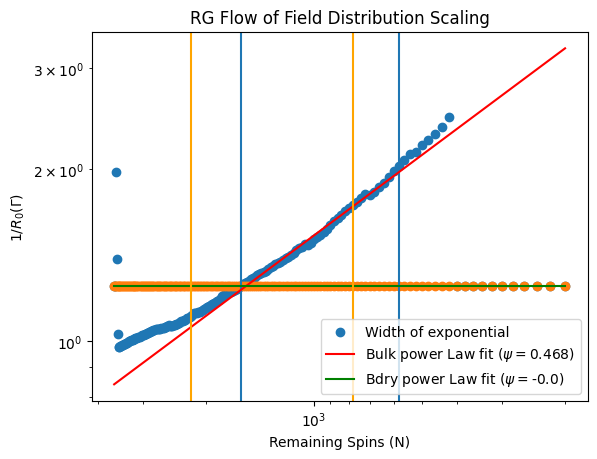

In [239]:
x = L*L - np.arange(len(R0_array_bulk))*measure_step
y_bulk = runs/R0_array_bulk
y_bdry = runs/R0_array_bdry
R_length = len(y_bulk)

start = 100
end = -20

plt.axvline(x = x[start])
plt.axvline(x = x[end])
plt.scatter(x, y_bulk, label='Width of exponential')#, yerr=np.sqrt(np.array(R0_array_err))/np.array(R0_array)**2)

plt.scatter(x, y_bdry)
#plt.yscale('log')

popt, pcov = curve_fit(power_law_scale, x[start:end], y_bulk[start:end])

plt.title("RG Flow of Field Distribution Scaling")
plt.xlabel("Remaining Spins (N)")
plt.ylabel(r"$1/R_0(\Gamma)$")
plt.plot(x, power_law_scale(x, *popt), color='red', label=r'Bulk power Law fit ($\psi=$'+str(round(popt[0], 4))+')')

start = 70
end = -30
popt, pcov = curve_fit(power_law_scale, x[start:end], y_bdry[start:end])
plt.plot(x, power_law_scale(x, *popt), c='green',label=r'Bdry power Law fit ($\psi=$'+str(round(popt[0], 4))+')')

plt.axvline(x = x[start], c='orange')
plt.axvline(x = x[end], c='orange')

plt.gca().invert_xaxis()
plt.legend()
plt.yscale('log')
plt.xscale('log')

#plt.xlim(1e4, 0.8*1e3)

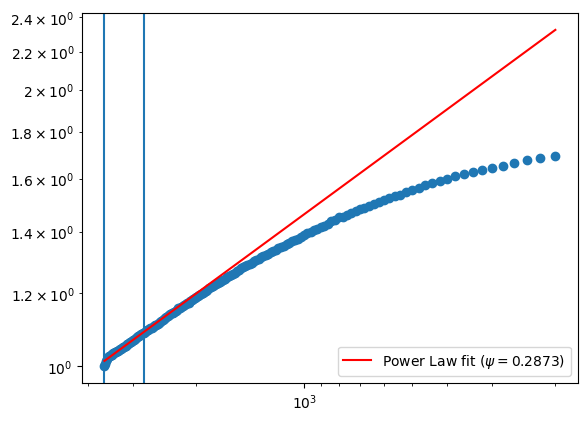

In [240]:
y = np.array(moment_array)

plt.scatter(x, y)

start = 0
end = 40

plt.axvline(x = x[start])
plt.axvline(x = x[end])
popt, pcov = curve_fit(power_law_scale, x[start:end], y[start:end])

plt.plot(x, power_law_scale(x, *popt), color='red', label=r'Power Law fit ($\psi=$'+str(round(popt[0], 4))+')')
plt.legend()
plt.yscale('log')
plt.xscale('log')
plt.gca().invert_xaxis()

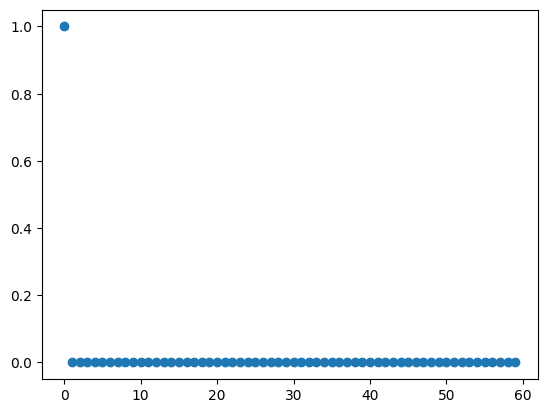

In [254]:

plt.scatter(x_array, ZZ_corr/runs)

In [15]:
#Cluster tracking using a dictionary
#Key is the lattice index, value is the index of the dictionary

L=3
start_dict = {i:i for i in range(L*L)}
reverse_dict = {i:[i] for i in range(L*L)}  #Cluster index is key and vals is set with lattice indices in cluster 

def update_cluster(cluster_dict, reverse_dict,site1, site2):
    #Takes in a dictionary containing the site->cluster mapping, cluster->set of sites mapping, and the two sites being decimated
    #Returns updated dictionaries, containing the new cluster data
    clust1 = cluster_dict[site1]   #cluster of site 1
    clust2 = cluster_dict[site2]   #cluster of site 2
    
    #Add spins in clust2 to clust1
    for dec_site in reverse_dict[clust2]:
        cluster_dict[dec_site] = clust1
    
    reverse_dict[clust1] += reverse_dict[clust2]
    reverse_dict[clust2] = None
    
    return cluster_dict, reverse_dict

In [28]:
start_dict, reverse_dict = update_cluster(start_dict, reverse_dict, 8, 0)

In [30]:
start_dict

{0: 8, 1: 8, 2: 8, 3: 3, 4: 4, 5: 5, 6: 8, 7: 8, 8: 8}